In [296]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [297]:
def backtest_strategy(data, initial_cash=10000):
    cash = initial_cash
    position = 0
    portfolio_value = [] 

    for i in range(len(data)):
        if pd.isna(data['BB_Lower'].iloc[i]) or pd.isna(data['BB_Upper'].iloc[i]):
            portfolio_value.append(cash + position * data['Close'].iloc[i])
            continue

        portfolio_value.append(cash + position * data['Close'].iloc[i])

        if data['Close'].iloc[i] < data['BB_Lower'].iloc[i] and position == 0:
            position = cash // data['Close'].iloc[i]  
            cash -= position * data['Close'].iloc[i]  
        
        elif data['Close'].iloc[i] > data['BB_Upper'].iloc[i] and position > 0:
            cash += position * data['Close'].iloc[i] 
            position = 0  

    portfolio_value_series = pd.Series(portfolio_value, index=data.index)
    return portfolio_value_series


In [298]:
def calculate_z_score(series, window=20):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    z_score = (series - mean) / std
    return z_score

def calculate_bollinger_bands(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

In [299]:
tech_stocks = ['AAPL', 'MSFT', 'NVDA', 'QQQ']

data = {}
for stock in tech_stocks:
    data[stock] = yf.download(stock, period="6mo", interval="1d") 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [300]:
for stock, df in data.items():

    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    df['Z_Score'] = calculate_z_score(df['Close'], window=20)

    df['BB_Upper'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'], window=20, num_std_dev=2)

    print(f"\nSample data for {stock}:")
    print(df[['Close', 'SMA_20', 'SMA_50', 'Z_Score', 'BB_Upper', 'BB_Lower']].tail())


Sample data for AAPL:
Price                           Close    SMA_20    SMA_50   Z_Score  \
Ticker                           AAPL                                 
Date                                                                  
2024-11-18 00:00:00+00:00  228.020004  227.6015  227.1814  0.103271   
2024-11-19 00:00:00+00:00  228.279999  227.2225  227.3448  0.296670   
2024-11-20 00:00:00+00:00  229.000000  227.1345  227.4716  0.533968   
2024-11-21 00:00:00+00:00  228.520004  227.0320  227.5866  0.435499   
2024-11-22 00:00:00+00:00  229.869995  226.9550  227.7340  0.875596   

Price                        BB_Upper    BB_Lower  
Ticker                                             
Date                                               
2024-11-18 00:00:00+00:00  235.706487  219.496513  
2024-11-19 00:00:00+00:00  234.351625  220.093374  
2024-11-20 00:00:00+00:00  234.121809  220.147191  
2024-11-21 00:00:00+00:00  233.865564  220.198436  
2024-11-22 00:00:00+00:00  233.613312  220.2

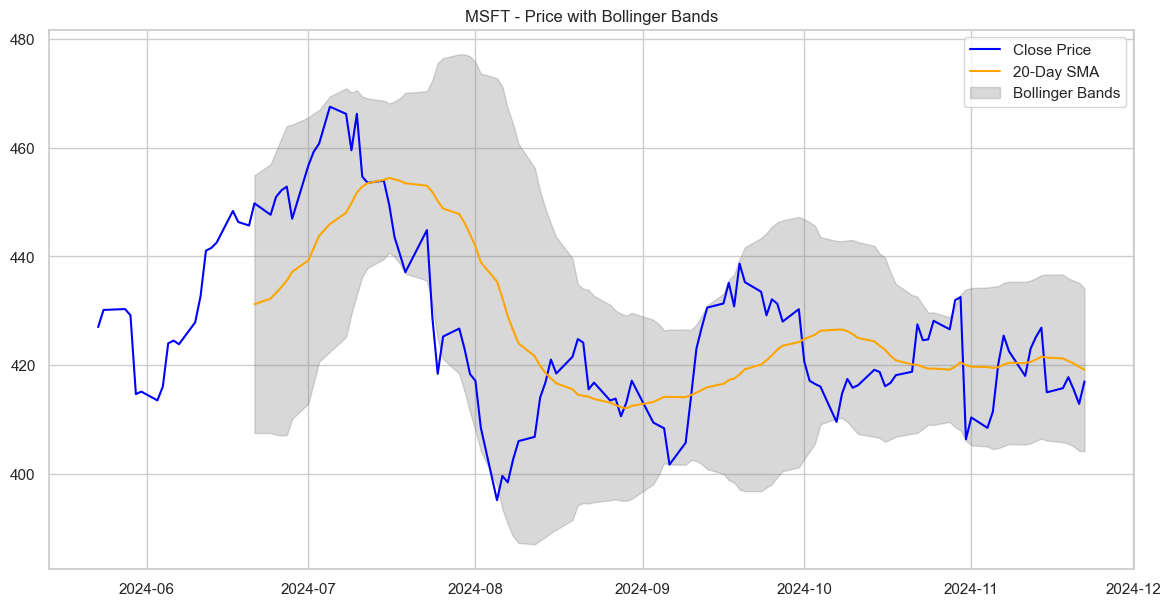

In [301]:
stock_to_plot = 'MSFT'
df = data[stock_to_plot]

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['SMA_20'], label='20-Day SMA', color='orange')
plt.fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color='grey', alpha=0.3, label='Bollinger Bands')
plt.title(f"{stock_to_plot} - Price with Bollinger Bands")
plt.legend()
plt.show()


In [302]:
def calculate_returns(portfolio_values):
    returns = portfolio_values.pct_change().dropna()  
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    returns = returns.dropna().astype(float)  
    if returns.empty or returns.std() == 0:
        return np.nan  
    excess_returns = returns - (risk_free_rate / 252)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
    return sharpe_ratio

def calculate_sortino_ratio(returns, risk_free_rate=0.01):
    returns = returns.dropna().astype(float)
    if returns.empty or returns.std() == 0:
        return np.nan 
    excess_returns = returns - (risk_free_rate / 252)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() if not downside_returns.empty else np.nan
    sortino_ratio = (excess_returns.mean() / downside_std * np.sqrt(252)) if downside_std else np.nan
    return sortino_ratio

def calculate_alpha_ratio(returns, benchmark_returns, risk_free_rate=0.01):
    excess_portfolio_return = returns - risk_free_rate / 252
    excess_benchmark_return = benchmark_returns - risk_free_rate / 252
    covariance = np.cov(excess_portfolio_return, excess_benchmark_return)[0, 1]
    variance = np.var(excess_benchmark_return)
    beta = covariance / variance
    alpha = np.mean(excess_portfolio_return) - beta * np.mean(excess_benchmark_return)
    return alpha * 252  


In [303]:
portfolio_values = {}
for stock, df in data.items():
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Z_Score'] = calculate_z_score(df['Close'], window=20)
    df['BB_Upper'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'], window=20, num_std_dev=2)

    print(f"\nBacktesting strategy for {stock}...")
    portfolio_values[stock] = backtest_strategy(df)




Backtesting strategy for AAPL...

Backtesting strategy for MSFT...

Backtesting strategy for NVDA...

Backtesting strategy for QQQ...


In [304]:
for stock, portfolio_value_series in portfolio_values.items():
    portfolio_returns = portfolio_value_series.pct_change().dropna()
    sharpe_ratio = calculate_sharpe_ratio(portfolio_returns)
    sortino_ratio = calculate_sortino_ratio(portfolio_returns)

    print(f"\nMetrics for {stock}:")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")



Metrics for AAPL:
Sharpe Ratio: nan
Sortino Ratio: nan

Metrics for MSFT:
Sharpe Ratio: nan
Sortino Ratio: nan

Metrics for NVDA:
Sharpe Ratio: nan
Sortino Ratio: nan

Metrics for QQQ:
Sharpe Ratio: nan
Sortino Ratio: nan


C:\Users\keish\AppData\Local\Temp\ipykernel_7440\3565315555.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  returns = returns.dropna().astype(float)
C:\Users\keish\AppData\Local\Temp\ipykernel_7440\3565315555.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  returns = returns.dropna().astype(float)
C:\Users\keish\AppData\Local\Temp\ipykernel_7440\3565315555.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  returns = returns.dropna().astype(float)
C:\Users\keish\AppData\Local\Temp\ipykernel_7440\3565315555.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  returns = returns.dropna().asty